XBOOST

In [7]:
# ---------------------------
# Notebook başına ekle
# ---------------------------

import sys
import os
import pandas as pd
import numpy as np

# ---------------------------
# Repo root klasörünü sabit path olarak ekle
# ---------------------------
repo_root = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml"
if repo_root not in sys.path:
    sys.path.append(repo_root)

# ---------------------------
# Fonksiyonları import et
# ---------------------------
from scripts.clean_data import clean_immo_data
from scripts.xgboost_model import run_xgb_pipeline_basic, plot_xgb_pipeline_results

# ---------------------------
# Veriyi temizle ve yükle
# ---------------------------
file_path = os.path.join(repo_root, "data", "immovlan_cleaned_file_final.csv")
df = clean_immo_data(file_path)

# ---------------------------
# XGBoost pipeline çalıştır
# ---------------------------
model_xgb, X_tr_xgb, X_val_xgb, X_test_xgb, y_tr_xgb, y_val_xgb, y_test_xgb = run_xgb_pipeline_basic(df.copy())

# ---------------------------
# Sonuçları görselleştir
# ---------------------------
plot_xgb_pipeline_results(model_xgb, X_tr_xgb, X_val_xgb, X_test_xgb, y_tr_xgb, y_val_xgb, y_test_xgb)


ModuleNotFoundError: No module named 'scripts.xgboost_model'

In [ ]:
# CSV dosyasını oku
file_path = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml\data\immovlan_cleaned_file_final.csv"
df = pd.read_csv(file_path)

# Price boş olanları çıkar
df = df.dropna(subset=['Price'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from xgboost import XGBRegressor

# =========================================================
# 🔥 MASTER FUNCTION — Pipeline 1 (Basic XGBoost)
# =========================================================
def run_xgb_pipeline_basic(df):
    """
    Pipeline 1: Simple XGBoost
    """

    # -----------------------------
    # 0️⃣ Remove price <= 1 & drop unwanted columns
    # -----------------------------
    df = df[df['Price'] > 1]
    
    drop_cols = [
        'Property ID', 'url', 'Availability', 'Attic', 'Kitchen equipment',
        'Kitchen type', 'Furnished', 'Price_per_sqm_land', 'price_per_sqm',
        'Number of facades', 'Number of bathrooms', 'Number of showers',
        'Number of toilets', 'Surface garden', 'Type of glazing'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    
    # -----------------------------
    # 1️⃣ Split train / val / test
    # -----------------------------
    X = df.drop(columns=['Price'])
    y = df['Price']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
    X_val_df   = pd.DataFrame(X_val, columns=X.columns, index=y_val.index)
    X_test_df  = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

    # -----------------------------
    # 2️⃣ Missing value handling
    # -----------------------------
    zero_cols = ['Garage', 'Number of garages', 'Swimming pool', 'Terrace', 
                 'Elevator', 'Garden']

    for col in zero_cols:
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna(0, inplace=True)

    categorical_cols = ['Type of heating', 'State of the property']
    for col in categorical_cols:
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna('unknown', inplace=True)

    for df_ in [X_train_df, X_val_df, X_test_df]:
        df_['main_type'].fillna('unknown', inplace=True)

    # Total land surface special handling
    X_train_df.loc[X_train_df['main_type']=='apartment', 'Total land surface'].fillna(0, inplace=True)
    X_val_df.loc[X_val_df['main_type']=='apartment', 'Total land surface'].fillna(0, inplace=True)
    X_test_df.loc[X_test_df['main_type']=='apartment', 'Total land surface'].fillna(0, inplace=True)

    house_median = X_train_df.loc[X_train_df['main_type']=='house', 'Total land surface'].median()
    land_median  = X_train_df.loc[X_train_df['main_type']=='land', 'Total land surface'].median()

    for df_ in [X_train_df, X_val_df, X_test_df]:
        df_.loc[(df_['main_type']=='house') & (df_['Total land surface'].isna()), 'Total land surface'] = house_median
        df_.loc[(df_['main_type']=='land') & (df_['Total land surface'].isna()), 'Total land surface'] = land_median

    num_cols_for_median = ['Number of bedrooms', 'Livable surface', 'Total land surface']
    for col in num_cols_for_median:
        median_dict = X_train_df.groupby('main_type')[col].median()
        for mtype, med_val in median_dict.items():
            for df_ in [X_train_df, X_val_df, X_test_df]:
                df_.loc[(df_['main_type']==mtype) & (df_[col].isna()), col] = med_val

    for col in num_cols_for_median:
        median_val = X_train_df[col].median()
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna(median_val, inplace=True)

    # -----------------------------
    # 3️⃣ Outlier removal (train only)
    # -----------------------------
    outlier_num_cols = ['Number of bedrooms', 'Livable surface', 'Garage', 'Number of garages', 
                        'Terrace', 'Total land surface', 'Swimming pool']

    df_normal_train_list = []

    y_train = y_train.reindex(X_train_df.index)

    for mtype, group in X_train_df.groupby('main_type'):
        group_copy = group.copy()
        group_copy['Price'] = y_train.loc[group_copy.index]
        z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))
        outliers = (z_scores > 3).any(axis=1)
        df_normal_train_list.append(group_copy[~outliers])

    df_normal_train = pd.concat(df_normal_train_list)

    # -----------------------------
    # 4️⃣ Features / target (use filtered y_tr!)
    # -----------------------------
    X_tr = df_normal_train.drop('Price', axis=1)
    y_tr = df_normal_train['Price']

    X_val_copy = X_val_df.copy()
    X_test_copy = X_test_df.copy()

    # -----------------------------
    # 4.1️⃣ Feature Engineering
    # -----------------------------
    feat_eng_cols = ['has_swimming_pool', 'has_garden', 'has_terrace', 'surface_ratio', 'area_per_bedroom']

    for df_ in [X_tr, X_val_copy, X_test_copy]:
        df_['has_swimming_pool'] = df_['Swimming pool'].apply(lambda x: 1 if x > 0 else 0)
        df_['has_garden'] = df_['Garden'].apply(lambda x: 1 if x > 0 else 0)
        df_['has_terrace'] = df_['Terrace'].apply(lambda x: 1 if x > 0 else 0)
        df_['surface_ratio'] = df_['Livable surface'] / df_['Total land surface'].replace(0,1)
        df_['area_per_bedroom'] = df_['Livable surface'] / df_['Number of bedrooms'].replace(0,1)

    # -----------------------------
    # 5️⃣ Encoding categorical variables (rare city)
    # -----------------------------
    cat_cols = ['State of the property', 'Type of heating','type', 
                'city', 'Region', 'province', 'main_type']

    rare_thresh = 10
    for df_ in [X_tr, X_val_copy, X_test_copy]:
        city_counts = df_['city'].value_counts()
        rare_cities = city_counts[city_counts < rare_thresh].index
        df_['city'] = df_['city'].replace(rare_cities, 'other')

    cat_cols_existing = [c for c in cat_cols if c in X_tr.columns]

    X_tr_encoded = pd.get_dummies(X_tr, columns=cat_cols_existing, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val_copy, columns=cat_cols_existing, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test_copy, columns=cat_cols_existing, drop_first=True)

    for col in feat_eng_cols:
        X_tr_encoded[col] = X_tr[col]
        X_val_encoded[col] = X_val_copy[col]
        X_test_encoded[col] = X_test_copy[col]

    train_cols = X_tr_encoded.columns
    X_val_encoded = X_val_encoded.reindex(columns=train_cols, fill_value=0)
    X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0)

    # -----------------------------
    # 6️⃣ Train simple XGBoost model
    # -----------------------------
    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr_encoded, y_tr)

    # -----------------------------
    # 7️⃣ Predictions
    # -----------------------------
    y_train_pred = model.predict(X_tr_encoded)
    y_val_pred = model.predict(X_val_encoded)
    y_test_pred = model.predict(X_test_encoded)

    # -----------------------------
    # 8️⃣ Evaluation
    # -----------------------------
    def evaluate(y_true, y_pred, label="Set"):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

    evaluate(y_tr, y_train_pred, "Train")
    evaluate(y_val, y_val_pred, "Validation")
    evaluate(y_test, y_test_pred, "Test")

    return model, X_tr_encoded, X_val_encoded, X_test_encoded, y_tr, y_val, y_test


In [ ]:
model1, X_tr1, X_val1, X_test1, y_tr1, y_val1, y_test1 = run_xgb_pipeline_basic(df.copy())


C:\Users\esram\AppData\Local\Temp\ipykernel_12644\2712796697.py:97: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))
C:\Users\esram\AppData\Local\Temp\ipykernel_12644\2712796697.py:97: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))


Train → RMSE: 71903.50, MAE: 46611.90, R²: 0.9261
Validation → RMSE: 165857.67, MAE: 77433.26, R²: 0.6611
Test → RMSE: 233940.46, MAE: 80687.66, R²: 0.6512


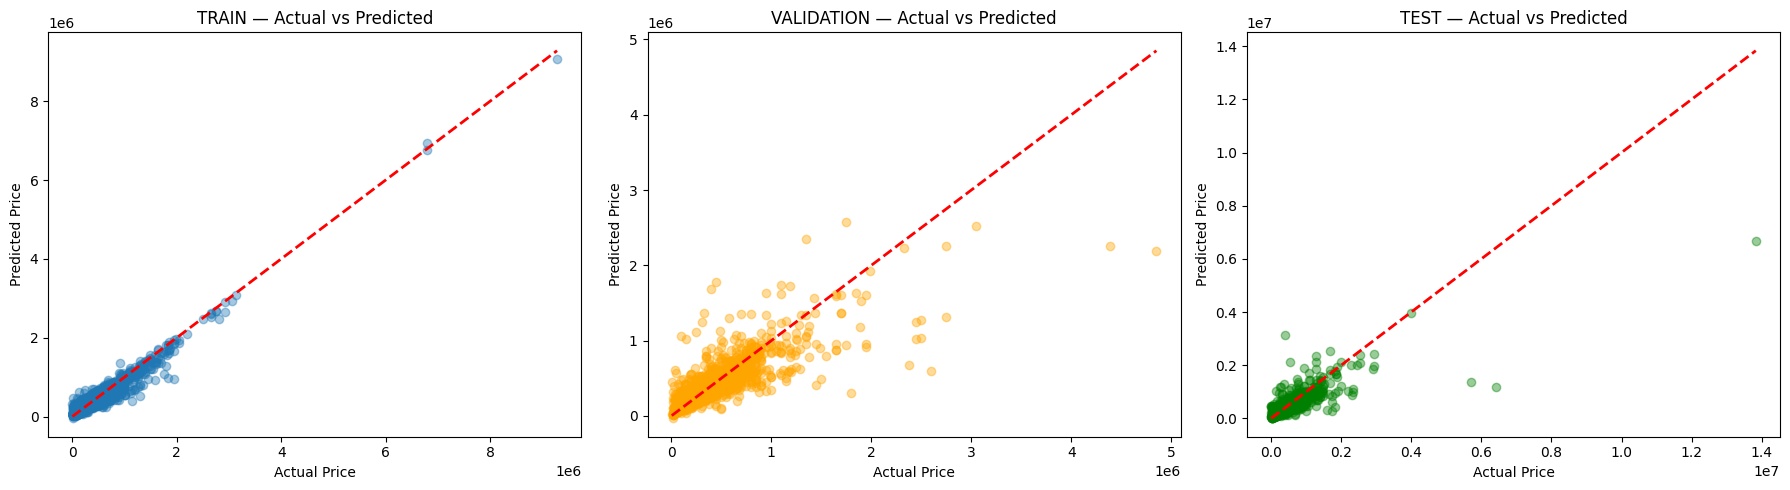

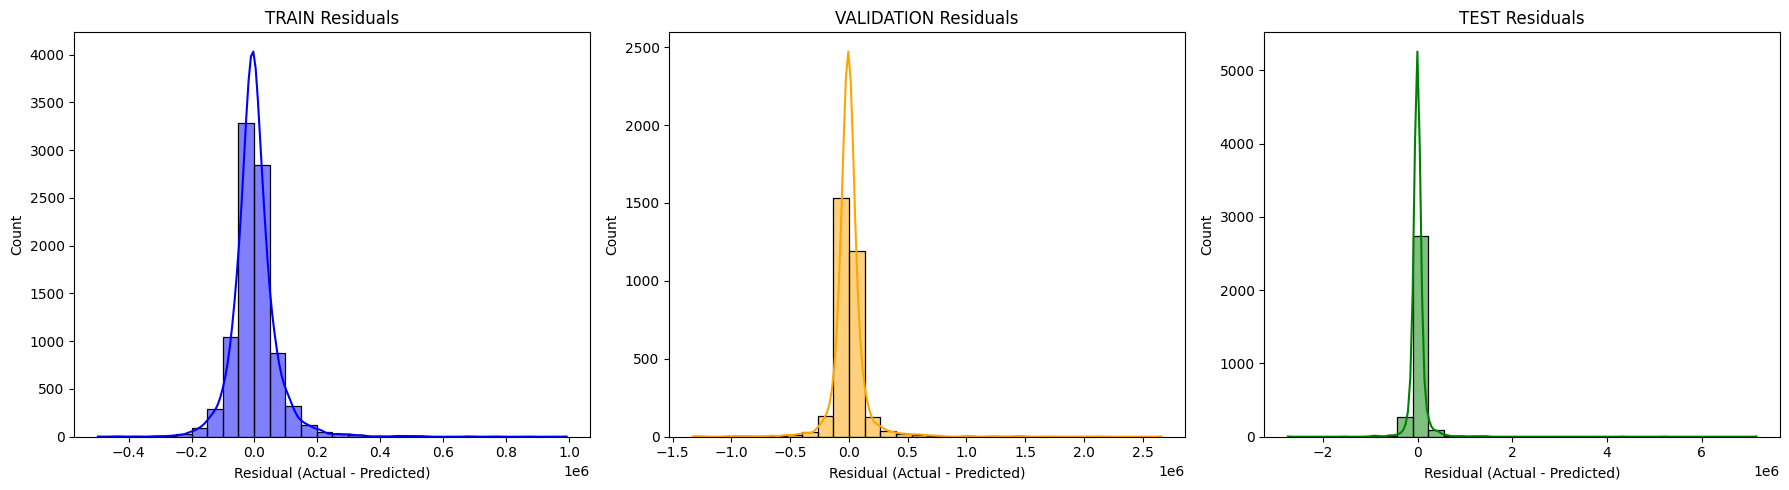

C:\Users\esram\AppData\Local\Temp\ipykernel_12644\1158214564.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


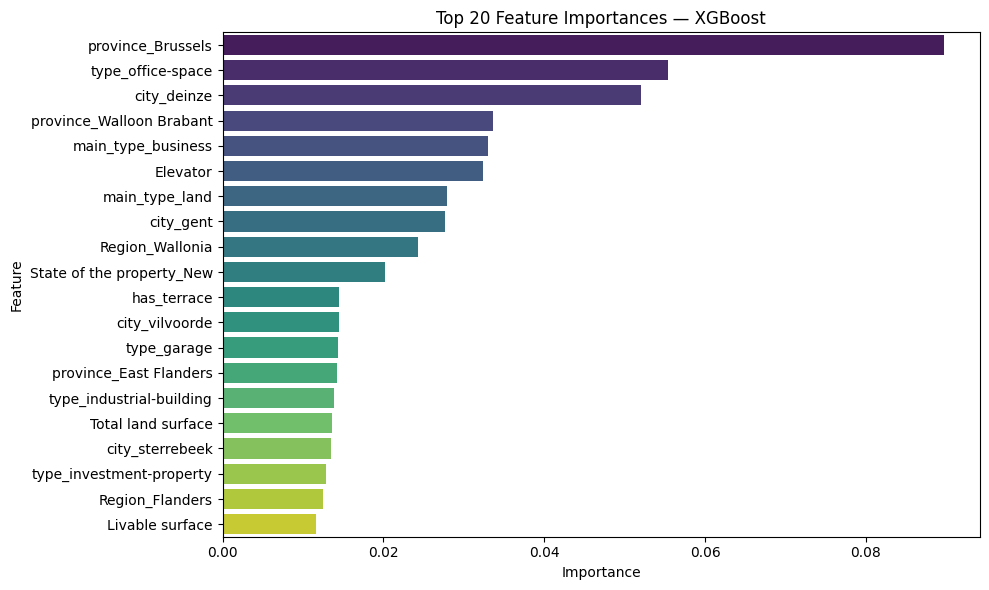

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_xgb_pipeline_results(model, X_tr, X_val, X_test, y_tr, y_val, y_test, top_n_features=20):
    """
    Plots for XGBoost Pipeline 1:
    1️⃣ Actual vs Predicted (Train / Val / Test)
    2️⃣ Residual plots (Train / Val / Test)
    3️⃣ Feature importance
    """
    # ---- Predictions ----
    y_train_pred = model.predict(X_tr)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)
    
    # ---- Actual vs Predicted Plots ----
    plt.figure(figsize=(18,5))
    
    # Train
    plt.subplot(1,3,1)
    plt.scatter(y_tr, y_train_pred, alpha=0.4)
    plt.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'r--', linewidth=2)
    plt.title("TRAIN — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    # Validation
    plt.subplot(1,3,2)
    plt.scatter(y_val, y_val_pred, alpha=0.4, color='orange')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
    plt.title("VALIDATION — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    # Test
    plt.subplot(1,3,3)
    plt.scatter(y_test, y_test_pred, alpha=0.4, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.title("TEST — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.tight_layout()
    plt.show()
    
    # ---- Residual Plots ----
    plt.figure(figsize=(18,5))
    
    # Train Residuals
    plt.subplot(1,3,1)
    sns.histplot(y_tr - y_train_pred, bins=30, kde=True, color='blue')
    plt.title("TRAIN Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    # Validation Residuals
    plt.subplot(1,3,2)
    sns.histplot(y_val - y_val_pred, bins=30, kde=True, color='orange')
    plt.title("VALIDATION Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    # Test Residuals
    plt.subplot(1,3,3)
    sns.histplot(y_test - y_test_pred, bins=30, kde=True, color='green')
    plt.title("TEST Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    plt.tight_layout()
    plt.show()
    
    # ---- Feature Importance ----
    importance = model.feature_importances_
    feature_names = X_tr.columns
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(top_n_features)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title(f"Top {top_n_features} Feature Importances — XGBoost")
    plt.tight_layout()
    plt.show()


